In [2]:
import pandas as pd
import numpy as np
import os
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_approximation import Nystroem
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, log_loss, classification_report, ConfusionMatrixDisplay
import joblib

In [3]:
# Function to load CSV files from a directory and assign labels
def load_csvs_from_folder(folder_path, label):
    csv_files = glob(os.path.join(folder_path, '*.csv'))
    dataframes = []
    for file in csv_files:
        df = pd.read_csv(file)
        df['Class'] = label  # Assign class label (0 for animal, 1 for plant)
        dataframes.append(df)
    return pd.concat(dataframes, ignore_index=True)

In [4]:
# Load data from two directories
animal_oils_folder = 'processed_data/Animal'
plant_oils_folder = 'processed_data/Plant'

In [5]:
# Load data for both classes
animal_oils_data = load_csvs_from_folder(animal_oils_folder, label=0)
plant_oils_data = load_csvs_from_folder(plant_oils_folder, label=1)

In [6]:
# Combine both datasets into a single DataFrame
df = pd.concat([animal_oils_data, plant_oils_data], ignore_index=True)

In [7]:
# Check the structure of the combined data
print(df.head())
print(df['Class'].value_counts())

        MQ2       MQ3      MQ4       MQ5       MQ6       MQ7       MQ8  \
0 -0.550251 -4.106784 -0.69598 -0.030151 -1.079146  2.332915  0.877513   
1  0.449749 -4.106784 -0.69598 -0.030151 -0.079146  2.332915  1.877513   
2 -0.550251 -4.106784  0.30402 -0.030151 -0.079146  2.332915  1.877513   
3 -0.550251 -5.106784  0.30402 -0.030151 -1.079146  1.332915 -0.122487   
4 -0.550251 -5.106784 -0.69598 -0.030151 -0.079146  1.332915 -0.122487   

        MQ9     MQ135     MQ137  Class  
0  2.719221 -0.912688  0.689698      0  
1  1.719221  1.087312  1.689698      0  
2  1.719221  0.087312  1.689698      0  
3  1.719221  0.087312  1.689698      0  
4  1.719221 -0.912688  1.689698      0  
Class
0    196175
1    190411
Name: count, dtype: int64


In [8]:
# Split features (X) and target (y)
X = df.drop(columns='Class')
y = df['Class']

In [9]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=32)

In [10]:
# More preprocessing measures
print(X_train.head())  # Quick view of the data
print(X_train.info())  # Check data types
print(X_train.isnull().sum())  # Check for null values

             MQ2        MQ3       MQ4       MQ5       MQ6       MQ7  \
184087 -1.433622  27.909940  0.197465 -0.503002  3.538359  2.178786   
367054  1.424400  23.078206  0.203337  0.475495 -9.290928 -5.577685   
185094 -1.433622  45.909940  1.197465  0.496998  2.538359  2.178786   
26412   3.406810  19.839904  3.584229  2.384707  7.147551  7.970729   
58065   0.552357  48.810597  1.186483  1.370046  2.880267  0.653734   

              MQ8        MQ9     MQ135      MQ137  
184087   7.436958   3.551701  0.149433  12.861241  
367054   0.772680  -3.397289  0.974974  17.217935  
185094  11.436958   5.551701  1.149433  28.861241  
26412    7.796296  12.856033  1.930108  15.821983  
58065    9.012933   5.858573  0.170630  32.776387  
<class 'pandas.core.frame.DataFrame'>
Index: 309268 entries, 184087 to 197719
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   MQ2     309268 non-null  float64
 1   MQ3     309268 non-null  float6

In [11]:
# Checking for non-numeric data
invalid_rows = X_train.map(lambda x: isinstance(x, str) and not x.isnumeric())
print(X_train[invalid_rows.any(axis=1)])  # Show rows with non-numeric data

Empty DataFrame
Columns: [MQ2, MQ3, MQ4, MQ5, MQ6, MQ7, MQ8, MQ9, MQ135, MQ137]
Index: []


In [12]:
# To handle unformatted values
# X_train = X_train.map(lambda x: x.replace('\x18', '') if isinstance(x, str) else x)
# X_test = X_test.map(lambda x: x.replace('\x18', '') if isinstance(x, str) else x)

In [13]:
# Data cleaning (as needed)


# Replace invalid entries with NaN
# X_train = X_train.replace({r'[^\d.]': np.nan}, regex=True)

# Convert the column to numeric, coercing errors to NaN
# X_train = X_train.apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN (optional, depending on your handling strategy)
# X_train = X_train.dropna()

In [14]:
# Define the pipeline with PCA, Nyström, and SGDClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Normalize data
    ('pca', PCA()),                # Dimensionality reduction
    ('nystroem', Nystroem()),      # Kernel approximation
    ('clf', SGDClassifier(loss='log_loss', max_iter=1000, random_state=32))  # SGD Classifier with logistic loss
])

In [15]:
# Define the hyperparameter search space
search_space = {
    'pca__n_components': Integer(2, min(X_train.shape[1], 9)),  # PCA components
    'nystroem__kernel': Categorical(['rbf', 'poly', 'cosine']),  # Nyström kernel
    'nystroem__gamma': Real(0.001, 1.0, prior='log-uniform'),    # Kernel coefficient
    'nystroem__n_components': Integer(50, 500),                 # Approximation rank
    'clf__alpha': Real(0.0001, 1.0, prior='log-uniform'),       # Regularization parameter
    'clf__penalty': Categorical(['l2', 'l1', 'elasticnet']),    # Penalty type
    'clf__learning_rate': Categorical(['optimal', 'invscaling', 'adaptive']),  # Learning rate schedule
    'clf__eta0': Real(0.001, 1.0, prior='log-uniform')          # Initial learning rate
}

# Use BayesSearchCV for hyperparameter optimization
opt = BayesSearchCV(
    pipeline, 
    search_space, 
    cv=5, 
    n_iter=12,  # Increase iterations for further refinement
    scoring='roc_auc', 
    random_state=32
)
opt.fit(X_train, y_train)

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                        ('pca', PCA()),
                                        ('nystroem', Nystroem()),
                                        ('clf',
                                         SGDClassifier(loss='log_loss',
                                                       random_state=32))]),
              n_iter=12, random_state=32, scoring='roc_auc',
              search_spaces={'clf__alpha': Real(low=0.0001, high=1.0, prior='log-uniform', transform='normalize'),
                             'clf__eta0': Real(low=0.001, high=1.0, prior=...
                             'clf__penalty': Categorical(categories=('l2', 'l1', 'elasticnet'), prior=None),
                             'nystroem__gamma': Real(low=0.001, high=1.0, prior='log-uniform', transform='normalize'),
                             'nystroem__kernel': Categorical(categories=('rbf', 'poly', 'cosine'), prior=None),
                             'nystroem__n_components': Integer(low=50, high=500, prior='uniform', transform='normalize'),
                             'pca__n_components': Integer(low=2, high=9, prior='uniform', transform='normalize')})

In [16]:
# Best model and its performance
print("Best Estimator:", opt.best_estimator_)
print("Best Score on Training Data:", opt.best_score_)
print("Score on Test Data:", opt.score(X_test, y_test))

Best Estimator: Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=5)),
                ('nystroem',
                 Nystroem(gamma=0.1508709600049789, n_components=245)),
                ('clf',
                 SGDClassifier(alpha=0.00013249022189739304,
                               eta0=0.006836244712030407, loss='log_loss',
                               penalty='l1', random_state=32))])
Best Score on Training Data: 0.9880921169374078
Score on Test Data: 0.9881820770426515


In [17]:
# Predictions
y_pred = opt.predict(X_test)

In [18]:
# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9544


In [19]:
# Save the best estimator
model_save_path = 'models/dec30_sgdclassifier_model.joblib'
joblib.dump(opt.best_estimator_, model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to models/dec30_sgdclassifier_model.joblib


In [20]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95     39235
           1       0.93      0.98      0.96     38083

    accuracy                           0.95     77318
   macro avg       0.96      0.95      0.95     77318
weighted avg       0.96      0.95      0.95     77318



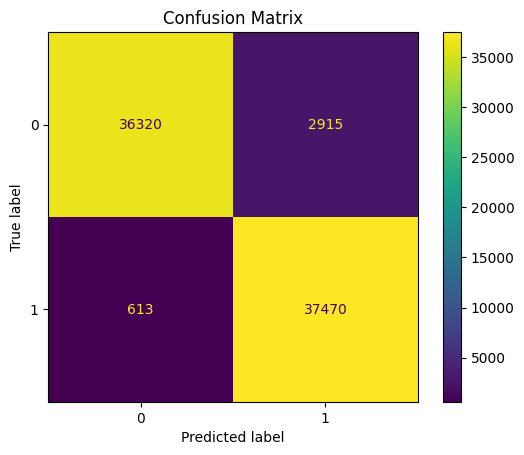

In [22]:
# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix")
plt.show()